In [16]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [17]:
%matplotlib inline
from __future__ import division
import matplotlib
import numpy as np
from pylab import *
import os
matplotlib.rcParams.update({"axes.formatter.limits": (-4,4)})
plotStyles={"markersize":20,"markeredgewidth":3.0,"linewidth":3.0}
stepStyles={"markersize":20,"markeredgewidth":3.0,"linewidth":3.0,"where":"post"}
np.seterr(divide='ignore',invalid='ignore')
pass

### Performance comparison
Generate the input files and output the commands to run the simulations. Before running, make sure to rename any existing perf.99.latest directory.

In [20]:
%%bash
dirname=perf/perf.99.latest
filename=${dirname}/first_order_birth_death.lm
mkdir -p ${dirname}
rm -f ${filename} && lm_sbml_import ${filename} first_order_birth_death.sbml > /dev/null
lm_setp ${filename} writeInterval=1e4 maxTime=1e5 > /dev/null
echo "Execute the following command in `pwd`:"
echo 'for replicate in `seq -f "%g" 0 10`; do'
echo "echo Running \${replicate};"
#echo "hostname=\`hostname\`"
#echo "lmesPrefix=/share/git/LatticeMicrobesES/build-gpu/"

#echo "hostname=barkeri"
#echo "solver=lm::cme::GillespieDSolver"
#echo "hostname=barkeri_nrm"
#echo "solver=lm::cme::NextReactionSolver"

#echo "hostname=spectre"
#echo "solver=lm::cme::GillespieDSolver"
echo "hostname=spectre_nrm"
echo "solver=lm::cme::NextReactionSolver"

#echo "lmesPrefix="
#echo "lmesPrefix=/Users/eroberts/Work/Lab/Git/LatticeMicrobesES-master/build/"
echo "\${lmesPrefix}lmes -r 1-15 -f ${filename} -c 2 -ff null -sl \${solver} -pf 60| tee ${filename}.\${hostname}.\${replicate}.log";
#echo "\${lmesPrefix}lmes -r 1-15 -f ${filename} -c 2 -ff null -sl lm::avx::GillespieDSolverAVX| tee ${filename}.\${hostname}.\${replicate}.log";
#echo "hostname=marcc"
#echo "lmes-submit ${filename} -r 1-15 -c 2 -ff null -sl lm::avx::GillespieDSolverAVX ${filename}.\${hostname}.\${replicate}.log parallel 24 erober32 00:20:00";
echo 'done;'

Execute the following command in /home/erober32/Work/Lab/Git/lmes/regression/cme_propensity_first_order_birth_death:
for replicate in `seq -f "%g" 0 10`; do
echo Running ${replicate};
hostname=spectre_nrm
solver=lm::cme::NextReactionSolver
${lmesPrefix}lmes -r 1-15 -f perf/perf.99.latest/first_order_birth_death.lm -c 2 -ff null -sl ${solver} -pf 60| tee perf/perf.99.latest/first_order_birth_death.lm.${hostname}.${replicate}.log
done;


In [12]:
# Extract the timing data.
import re
datadir="perf"
timingData={}
runtimeData={}
testNumberMap={}
regex0 = re.compile("perf\.(\d+).(\S+)")
regex1 = re.compile("\.lm\.([^\.]+)\.(\d+)\.log")
regex2 = re.compile("inished .+ seconds \((\S+) steps/second\)")
regex3 = re.compile("Replicate supervisor finished 15 replicates in (\S+) seconds.")
for dirname in os.listdir(datadir):
    testName = None
    m = regex0.search(dirname)
    if m != None:
        testNumber = m.group(1)
        testName = m.group(2)
        testNumberMap[testNumber] = testName
    if testName is not None:
        for logname in os.listdir(datadir+"/"+dirname):
            m = regex1.search(logname)
            if m != None:
                host=m.group(1)
                replicate=int(m.group(2))
                with open(datadir+"/"+dirname+"/"+logname) as f:
                    for line in f:
                        firstm2=True
                        m2 = regex2.search(line)
                        m3 = regex3.search(line)
                        if m2 != None:
                            if host not in timingData:
                                timingData[host]={}
                            if testName not in timingData[host]:
                                timingData[host][testName]=[]
                            if firstm2:
                                timingData[host][testName].append(double(m2.group(1)))
                                firstm2 = False;
                        if m3 != None:
                            if host not in runtimeData:
                                runtimeData[host]={}
                            if testName not in runtimeData[host]:
                                runtimeData[host][testName]=[]
                            runtimeData[host][testName].append(double(m3.group(1)))
print "Finished."

Finished.


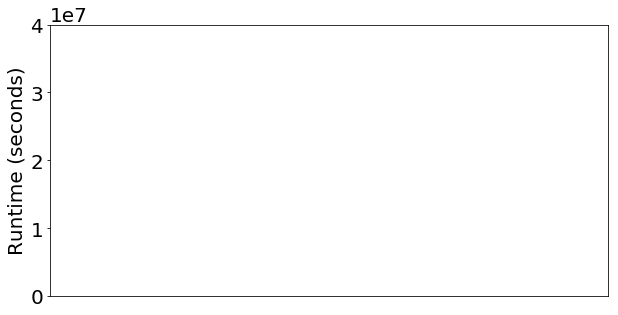

In [13]:
# Plot the latest runtime data.
matplotlib.rcParams.update({'font.size': 20, "figure.figsize": (10,5)})
allHosts = timingData.keys()
allHosts.sort()
hosts=[]
times=[]
timesErr=[]
for host in allHosts:
    if "latest" in timingData[host]:
        times.append(mean(timingData[host]['latest']))
        timesErr.append(std(timingData[host]['latest']))
        hosts.append(host)
plt.bar(arange(0,len(hosts))+0.25,times,width=0.5,yerr=timesErr, color='c', error_kw={"elinewidth":2,"capsize":5,"capthick":2})
plt.ylabel('Runtime (seconds)')
plt.xticks(arange(0,len(hosts))+0.5, hosts)
plt.ylim([0,4e7])
pass

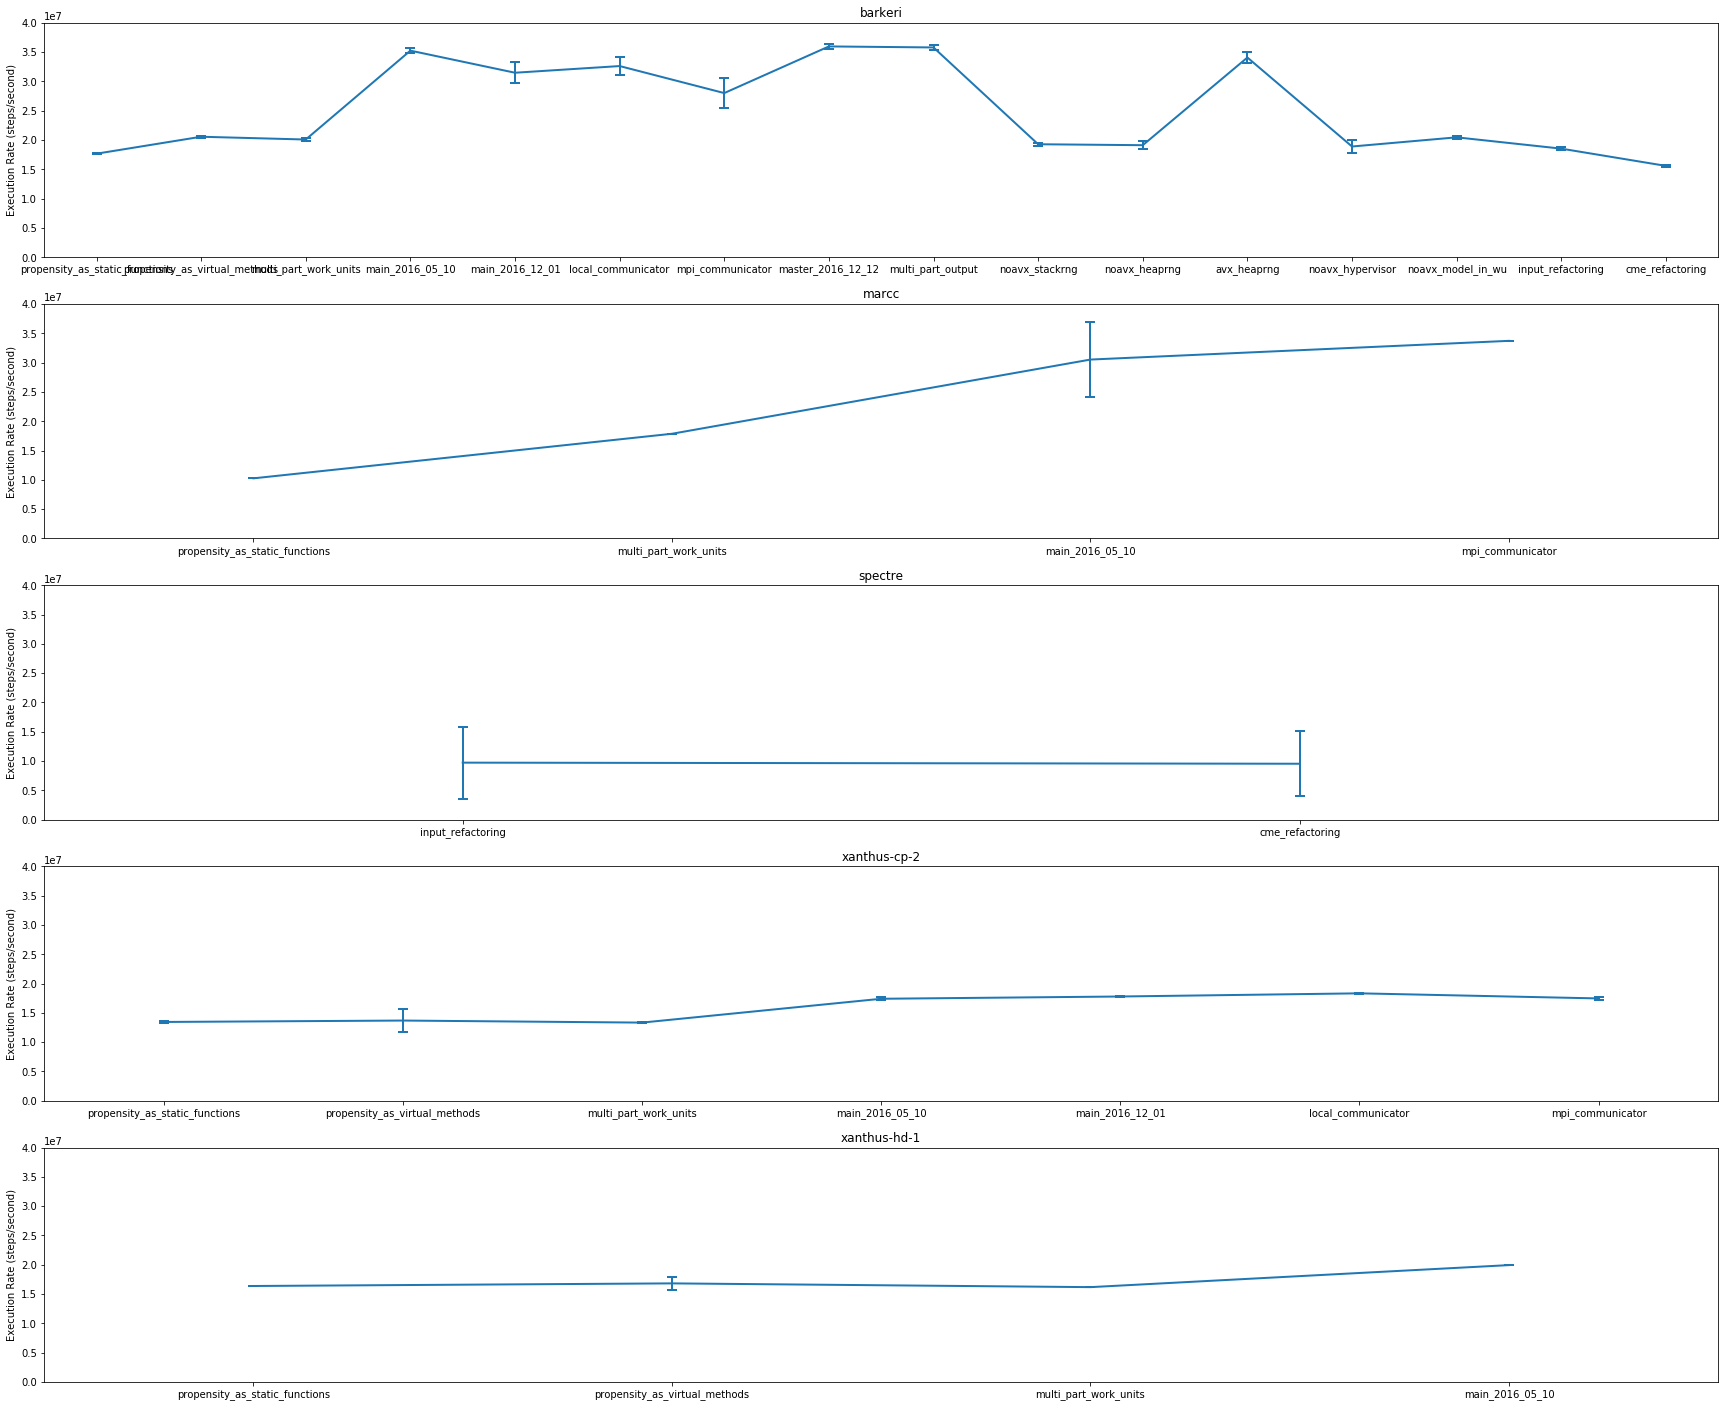

In [14]:
# Plot the previous timing data.
matplotlib.rcParams.update({'font.size': 10, "figure.figsize": (30,25)})
hosts = timingData.keys()
hosts.sort()
testNumbers = testNumberMap.keys()
testNumbers.sort()
for i,host in enumerate(hosts):
    times=[]
    timesErr=[]
    testNames=[]
    for testNumber in testNumbers:
        testName = testNumberMap[testNumber]
        if testName in timingData[host]:
            times.append(mean(timingData[host][testName]))
            timesErr.append(std(timingData[host][testName]))
            testNames.append(testName)
    plt.subplot(len(hosts),1,i+1)
    plt.errorbar(arange(0,len(testNames))+0.5,times,linewidth=2,yerr=timesErr,elinewidth=2,capsize=5,capthick=2)
    plt.ylabel('Execution Rate (steps/second)')
    plt.xticks(arange(0,len(testNames))+0.5, testNames)
    plt.xlim([0,len(testNames)]); plt.ylim([0,4e7])
    plt.title(host)
pass

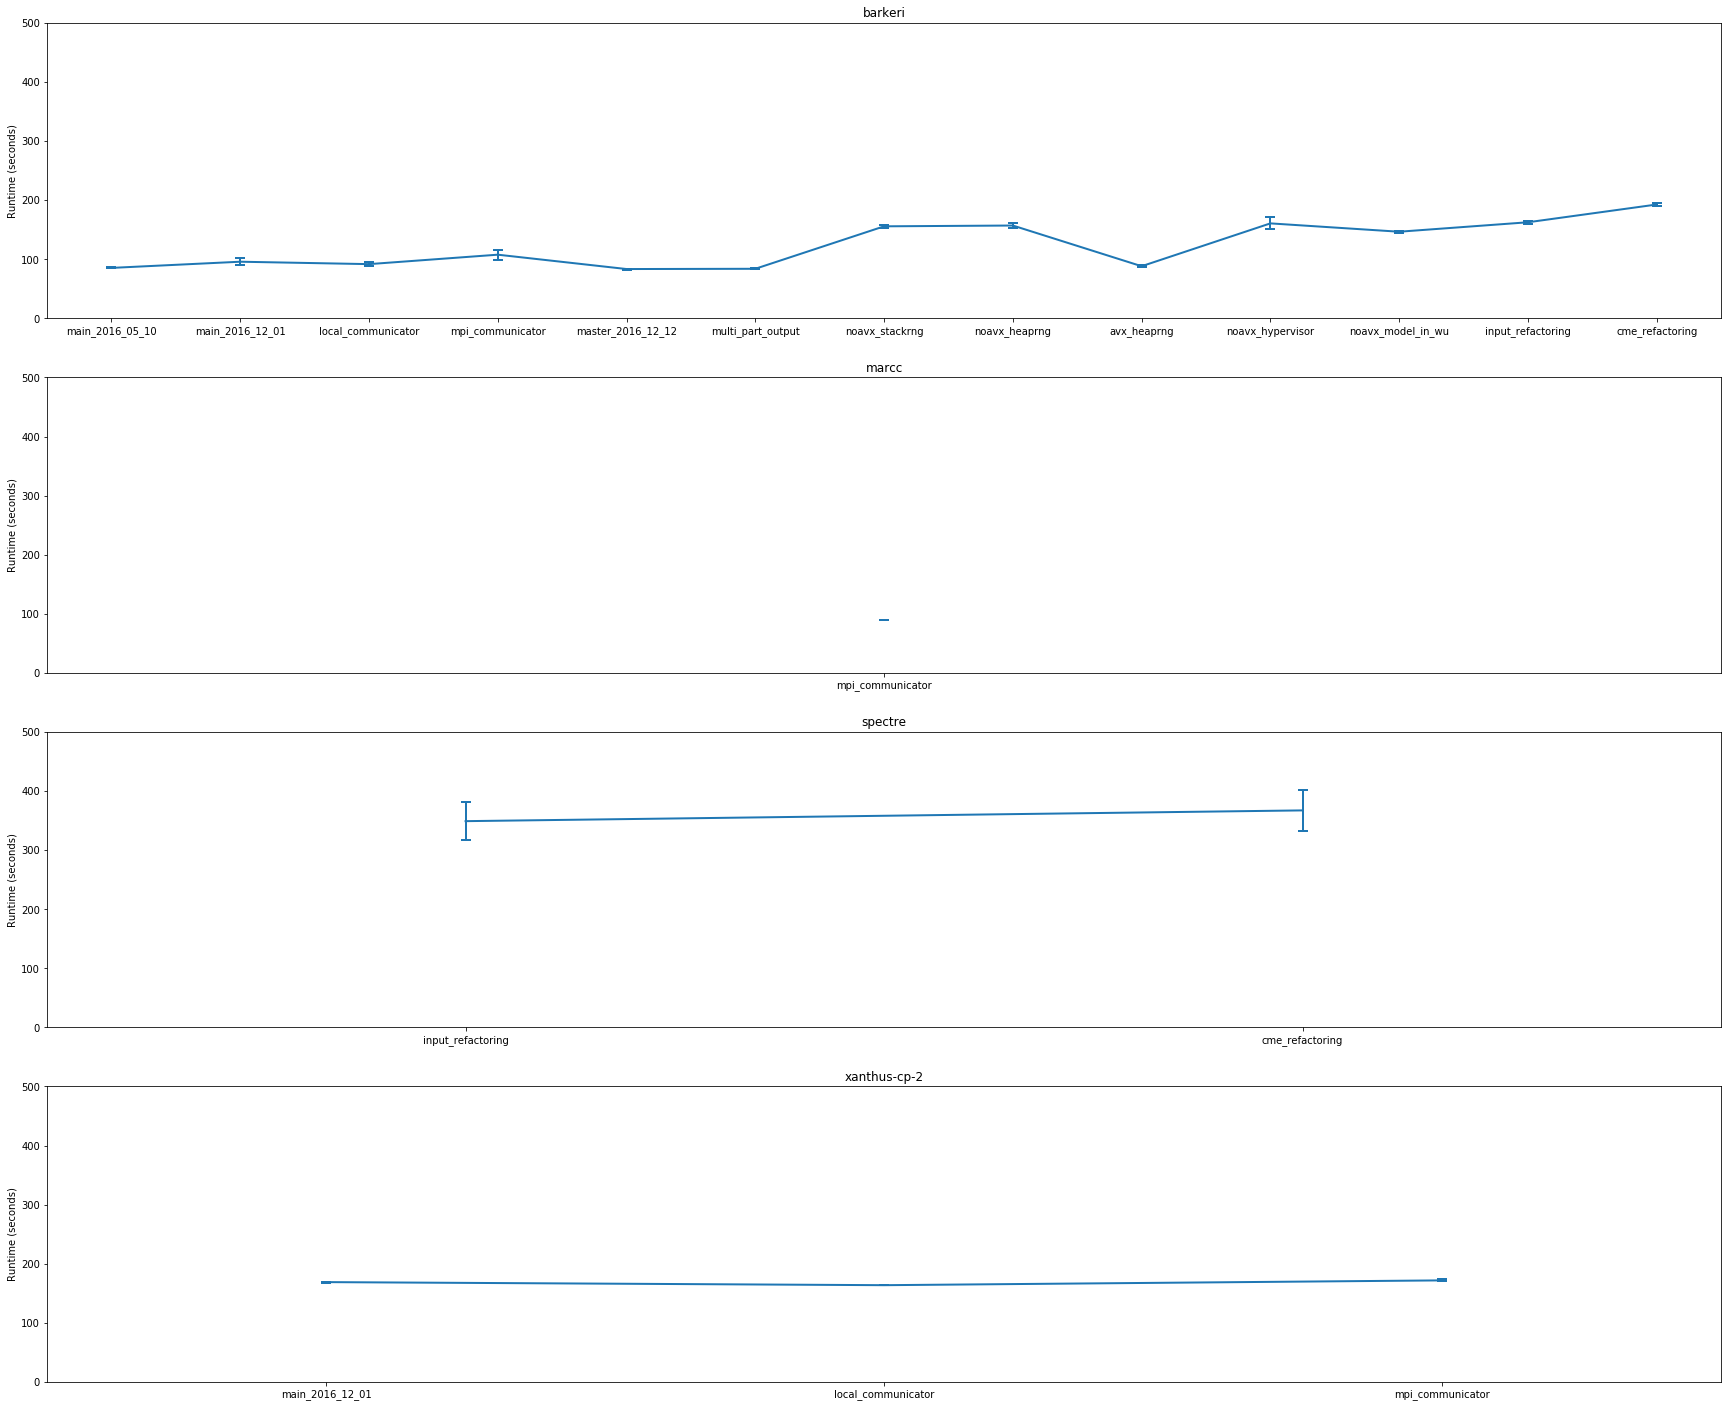

In [15]:
# Plot the previous timing data.
matplotlib.rcParams.update({'font.size': 10, "figure.figsize": (30,25)})
hosts = runtimeData.keys()
hosts.sort()
testNumbers = testNumberMap.keys()
testNumbers.sort()
for i,host in enumerate(hosts):
    times=[]
    timesErr=[]
    testNames=[]
    for testNumber in testNumbers:
        testName = testNumberMap[testNumber]
        if testName in runtimeData[host]:
            times.append(mean(runtimeData[host][testName]))
            timesErr.append(std(runtimeData[host][testName]))
            testNames.append(testName)
    plt.subplot(len(hosts),1,i+1)
    plt.errorbar(arange(0,len(testNames))+0.5,times,linewidth=2,yerr=timesErr,elinewidth=2,capsize=5,capthick=2)
    plt.ylabel('Runtime (seconds)')
    plt.xticks(arange(0,len(testNames))+0.5, testNames)
    plt.xlim([0,len(testNames)]); plt.ylim([0,500])
    plt.title(host)
pass

### Performance comparison with a fully utilized node

In [274]:
%%bash
dirname=data/perf_full.99.latest
filename=${dirname}/first_order_birth_death.lm
mkdir -p ${dirname}
rm -f ${filename} && lm_sbml_import ${filename} first_order_birth_death.sbml
lm_setp ${filename} writeInterval=1e4 maxTime=1e5
cpus=24
trajectories=$((15*cpus))
echo "Execute the following command in `pwd`:"
echo "trajectories=${trajectories};"
echo 'for replicate in `seq -f "%g" 0 10`; do'
echo "echo Running \${replicate};"
#echo "hostname=\`hostname\`"
#echo "lmesPrefix=/share/git/LatticeMicrobesES/build/"
#echo "hostname=barkeri"
#echo "lmesPrefix="
#echo "hostname=marcc"
#echo "lmesPrefix=/home-2/erober32@jhu.edu/share/git/LatticeMicrobesES/build-icc/"
#echo "\${lmesPrefix}lmes -r 1-${trajectories} -f ${filename} -c ${cpus} -gr 0 -ff null -sl lm::cme::GillespieDSolver| tee ${filename}.\${hostname}.\${replicate}.log";
echo "\${lmesPrefix}lmes --mpi -r 1-${trajectories} -f ${filename} -c ${cpus} -gr 0 -ff null -sl lm::avx::GillespieDSolverAVX| tee ${filename}.\${hostname}.\${replicate}.log";
echo 'done;'


lm_sbml_import v2016.01.20 build 1
Copyright (C) 2008-2012 Luthey-Schulten Group, University of Illinois at Urbana-Champaign.
Copyright (C) 2012-2016 Roberts Group, Johns Hopkins University.


Done.
lm_setp v2016.01.20 build 1
Copyright (C) 2008-2012 Luthey-Schulten Group,
University of Illinois at Urbana-Champaign.

Setting parameters in simulation file data/perf_full.99.latest/first_order_birth_death.lm:
maxTime=1e5
writeInterval=1e4
Done.
Execute the following command in /Users/eroberts/Work/Lab/Git/LatticeMicrobesES/regression/first_order_birth_death:
trajectories=360;
for replicate in `seq -f "%g" 0 10`; do
echo Running ${replicate};
hostname=marcc
lmesPrefix=/home-2/erober32@jhu.edu/share/git/LatticeMicrobesES/build-icc/
${lmesPrefix}lmes -r 1-360 -f data/perf_full.99.latest/first_order_birth_death.lm -c 24 -gr 0 -ff null -sl lm::avx::GillespieDSolverAVX| tee data/perf_full.99.latest/first_order_birth_death.lm.${hostname}.${replicate}.log
done;


In [279]:
# Extract the timing data.
datadir="data"
timingDataFull={}
testNumberMapFull={}
regex0 = re.compile("perf_full\.(\d+).(\S+)")
regex1 = re.compile("\.lm\.([^\.]+)\.(\d+)\.log")
regex2 = re.compile("Finished .+ seconds \((\S+) steps/second\)")
for dirname in os.listdir(datadir):
    testName = None
    m = regex0.search(dirname)
    if m != None:
        testNumber = m.group(1)
        testName = m.group(2)
        testNumberMapFull[testNumber] = testName
    if testName is not None:
        for logname in os.listdir(datadir+"/"+dirname):
            m = regex1.search(logname)
            if m != None:
                host=m.group(1)
                replicate=int(m.group(2))
                with open(datadir+"/"+dirname+"/"+logname) as f:
                    for line in f:
                        m = regex2.search(line)
                        if m != None:
                            if host not in timingDataFull:
                                timingDataFull[host]={}
                            if testName not in timingDataFull[host]:
                                timingDataFull[host][testName]=[]
                            timingDataFull[host][testName].append(double(m.group(1)))
                            break

[33424375.0, 33419090.90909091]


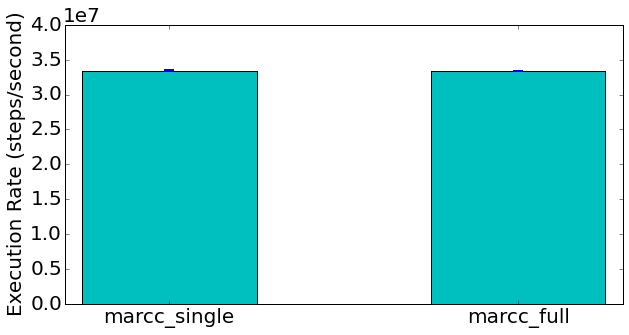

In [285]:
# Plot the latest timing data.
matplotlib.rcParams.update({'font.size': 20, "figure.figsize": (10,5)})
hosts = timingDataFull.keys()
hosts.sort()
times=[]
timesErr=[]
plotHosts=[]
for host in hosts:
    if "latest" in timingDataFull[host]:
        times.append(mean(timingData[host]['latest']))
        timesErr.append(std(timingData[host]['latest']))
        plotHosts.append("%s_%s"%(host,"single"))
        times.append(mean(timingDataFull[host]['latest']))
        timesErr.append(std(timingDataFull[host]['latest']))
        plotHosts.append("%s_%s"%(host,"full"))
print times
plt.bar(arange(0,len(plotHosts))+0.25,times,width=0.5,yerr=timesErr, color='c', error_kw={"elinewidth":2,"capsize":5,"capthick":2})
plt.ylabel('Execution Rate (steps/second)')
plt.xticks(arange(0,len(plotHosts))+0.5, plotHosts)
plt.ylim([0,4e7])
pass